In [1]:
import sys, pickle
sys.path.append('../src')
import numpy as np
from scipy.linalg import svd
from scipy.stats import permutation_test, wilcoxon
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import *
from helper_funcs import *
from visualization import plot_mean_std
rng = np.random.default_rng()

In [2]:
XS_PERT = np.linspace(0, 1, num=6) # off manifold (perturbation)
XS_SCALE = np.linspace(0, 1, num=6) # on manifold (song scaling)

In [3]:
rate_onm, rate_offm = [], []
svds = []
mode = 'shuffleAll'
for i in tqdm(range(1,11)):
    with open(f'../results/EI_rec_J_disr_exp_meta_{i}.pkl', 'rb') as f:
        res = pickle.load(f)
        # syl is directly derived from the input data, so all are the same
        syl = res['syl']
        svds.append(res['svds'])
    
    with open(f'../results/EIrec_J_disr_exp_{mode}_{i}.pkl', 'rb') as f:
        res = pickle.load(f)
    
    NE = syl.shape[1]
    
    rate_onm += res['on_manifold']
    rate_offm += res['off_manifold']

    J = svds[-1][-1][0] @ np.diag(svds[-1][-1][1]) @ svds[-1][-1][2]
    
print(res['order'])
n_case = len(res['order'])
n_shuffle = len(res['on_manifold'])

# (simulations, cases, pert values, NE)
rate_onm, rate_offm = np.stack(rate_onm), np.stack(rate_offm)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.46it/s]

['original', 'memory', 'landscape', 'rand']


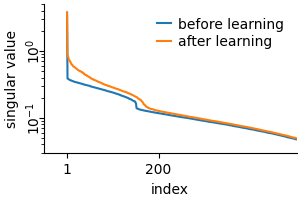

In [4]:
fig, ax = plt.subplots(1, figsize=(3, 2))
i = np.arange(1, len(svds[0][0][1])+1)
ax.plot(i, svds[0][0][1], label='before learning')
ax.plot(i, svds[0][-1][1], label='after learning')
ax.legend()
ax.set(yscale='log', ylim=[3e-2, 5], xlim=[-50, 500], xticks=[1, 200],
       ylabel='singular value', xlabel='index')
ax.set_yticks([1e-1, 1], labels=['$10^{-1}$', '$10^0$'], 
              ha='center', va='center', rotation=90)
fig.savefig(f'../svg/EIrec_analysis/{mode}_log_singular_value.svg')

[3 4] [ 2  3  4  5  9 11]


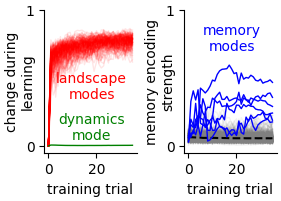

In [5]:
change, i_outlier, i_nonout = characterize_change(svds[1], first_n=150)
mem_enc, i_memory, i_nonmem = characterize_memory(svds[1], syl, 'left')
i_landscape = [i for i in i_nonmem if i != 0 and i < 150]

print(i_outlier + 1, i_memory + 1)

fig, ax = plt.subplots(1, 2, figsize=(2.8,2))

ax[0].plot(change[:,i_landscape], c='r', alpha=0.1, lw=1, zorder=-1)
ax[0].text(change.shape[0]//2, 0.35, 'landscape\nmodes', ha='center', c='r')
# ax[0].plot(change[:,i_memory], c='b', alpha=0.6, lw=1, zorder=-1)
# ax[0].plot(change[:,150:], c='purple', alpha=0.1, lw=1, zorder=-1)
# ax[0].plot(change, c='grey', alpha=0.1, lw=1, zorder=-1)
# ax[0].plot(change[:,1:].mean(axis=1), c='k', ls='--', zorder=1)
ax[0].plot(change[:,0], c='g', lw=1, zorder=2)
ax[0].text(change.shape[0]//2, 0.05, 'dynamics\nmode', ha='center', c='g')
ax[0].set(yticks=[0, 1], ylim=[-0.05, 1])
ax[0].set_ylabel('change during\nlearning', va='center')
ax[0].set_xlabel('training trial', va='top')
ax[1].set_rasterization_zorder(0)

ax[1].plot(mem_enc[:,i_nonmem], c='grey', alpha=0.1, lw=1, zorder=-1)
ax[1].plot(mem_enc[:,i_nonmem].mean(axis=1), c='k', ls='--', zorder=1)
ax[1].plot(mem_enc[:,i_memory], c='b', lw=1, alpha=1, zorder=1)
ax[1].text(change.shape[0]//2, 0.7, 'memory\nmodes', ha='center', c='b')
ax[1].set(ylim=[-0.05, 1], yticks=[0, 1])
ax[1].set_ylabel('memory encoding\nstrength', va='center')
ax[1].set_xlabel('training trial', va='top')
ax[1].set_rasterization_zorder(0)

fig.savefig(f'../svg/EIrec_analysis/{mode}_mode_learning_curves_E2I2E.svg')

In [6]:
def get_timeconst(x):
    xmin, xmax = x.min(axis=0), x.max(axis=0)
    x = (x - xmin) / (xmax - xmin)
    return np.where(x > 1 - 5**(-1))[0][0]

tc_landscape, tc_memory = [], []
for i in range(len(svds)):
    change = characterize_change(svds[i])[0]
    mem_enc, i_memory, i_nonmem = characterize_memory(svds[i], syl, 'left')
    i_landscape = i_nonmem[1:10] 
    tc_landscape.append(get_timeconst(change[:,i_landscape].mean(axis=1)))
    tc_memory.append(get_timeconst(mem_enc[:,i_memory].mean(axis=1)))

0.0009765625


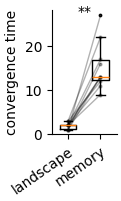

In [7]:
fig, ax = plt.subplots(1, figsize=(1.2,2))
for x, y in zip(tc_landscape, tc_memory):
    ax.plot([1, 2], [x, y], '-o', c='k', alpha=0.3, ms=2, lw=1)
ax.boxplot([tc_landscape, tc_memory], widths=[0.5, 0.5])
pval = wilcoxon(tc_landscape, tc_memory, alternative='less').pvalue
print(pval)
if pval < 0.05:
    ax.text(1.5, np.max(tc_memory), '**' if pval < 0.01 else '*', ha='center')
else:
    ax.text(1.5, np.max(tc_memory), 'ns', ha='center', va='bottom')
ax.set(ylim=[0, ax.get_ylim()[1]], ylabel='convergence time')
ax.set_xticklabels(['landscape', 'memory'], rotation=35, ha='right', rotation_mode='anchor')
fig.savefig(f'../svg/EIrec_analysis/{mode}_mode_time_constants.svg')

In [8]:
# case_names = ['original', 'without memory modes', 'without 10 landscape modes', 
#               'without 10 random other modes']
case_names = ['original', 'without memory modes', 'without top 15 landscape modes', 
              'without top 15 other modes']
case_colors = ['k', 'b', 'r', 'purple']

1.6526741834589804e-10
3.666040634210131e-15
0.023748551357027522
2.0407900706788985e-05


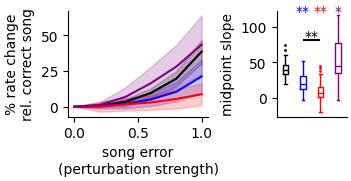

In [9]:
from scipy.stats import ranksums
fig, ax = plt.subplots(1, 2, figsize=(3.5,1.8), width_ratios=[1,0.5])

m = rate_offm.mean(axis=-1)
m = (m / m[...,0,None] - 1) * 100
g = np.gradient(m, XS_PERT, axis=-1)[...,3]

for i, c in enumerate(case_colors):
    plot_mean_std(ax[0], m[:,i].mean(axis=0), m[:,i].std(axis=0), 
                  a_fill=0.2, c=c, xs=XS_PERT)
    ax[1].boxplot(g[:,i], positions=[i], 
                  widths=0.3, flierprops=dict(ms=2, mec=c), 
                  boxprops=dict(color=c), capprops=dict(color=c),
                  whiskerprops=dict(color=c), medianprops=dict(color=c))
    if i > 0:
        pval = ranksums(g[:,0], g[:,i]).pvalue
        print(pval)
        if pval < 0.05:
            ax[1].text(i, g.max(), '**' if pval < 0.01 else '*', ha='center', c=c)
        else:
            ax[1].text(i, g.max(), 'ns', ha='center', va='bottom', c=c)
pval, y = ranksums(g[:,1], g[:,2]).pvalue, g.max() * 0.7
print(pval)
ax[1].hlines(y, 1, 2, color='k')
if pval < 0.05:
    ax[1].text(1.5, y, '**' if pval < 0.01 else '*', ha='center', c='k')
else:
    ax[1].text(1.5, y, 'ns', ha='center', va='bottom', c='k')
ax[0].set(xlabel='song error\n(perturbation strength)', 
          ylabel='% rate change\nrel. correct song')
ax[1].set(xticks=[], ylabel='midpoint slope')
fig.savefig(f'../svg/EIrec_analysis/{mode}_off_manifold_perturb.svg')

5.485161262958621e-16
0.8631659180932314
6.338272833367523e-17


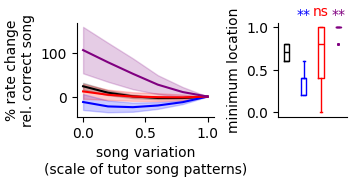

In [10]:
from scipy.stats import ranksums
fig, ax = plt.subplots(1, 2, figsize=(3.5,1.8), width_ratios=[1,0.5])

m = rate_onm.mean(axis=-1)
m = (m / m[...,-1,None] - 1) * 100
min_locs = XS_SCALE[np.argmin(m, axis=-1)]

for i, c in enumerate(case_colors):
    plot_mean_std(ax[0], m[:,i].mean(axis=0), m[:,i].std(axis=0), 
                  a_fill=0.2, c=c, xs=XS_SCALE)
    ax[1].boxplot(min_locs[:,i], positions=[i],
                  widths=0.3, flierprops=dict(ms=2, mec=c), 
                  boxprops=dict(color=c), capprops=dict(color=c),
                  whiskerprops=dict(color=c), medianprops=dict(color=c))
    if i > 0:
        pval = ranksums(min_locs[:,0], min_locs[:,i]).pvalue
        print(pval)
        if pval < 0.05:
            ax[1].text(i, 1.1, '**' if pval < 0.01 else '*', ha='center', c=c)
        else:
            ax[1].text(i, 1.1, 'ns', ha='center', va='bottom', c=c)
ax[0].set(xlabel='song variation\n(scale of tutor song patterns)', 
          ylabel='% rate change\nrel. correct song')
ax[1].set(xticks=[], ylabel='minimum location')
fig.savefig(f'../svg/EIrec_analysis/{mode}_on_manifold_perturb.svg')

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [6.85664145e-18 6.85664145e-18 6.85664145e-18 6.85664145e-18
  6.85664145e-18 1.89460234e-17]
 [6.85664145e-18 6.85664145e-18 6.85664145e-18 6.85664145e-18
  6.85664145e-18 6.85664145e-18]
 [6.85664145e-18 6.85664145e-18 6.85664145e-18 6.85664145e-18
  6.85664145e-18 6.85664145e-18]]


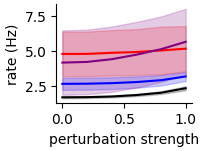

In [11]:
fig, ax = plt.subplots(1, figsize=(2,1.5))

m = rate_offm.mean(axis=-1)

for i, c in enumerate(case_colors):
    plot_mean_std(ax, m[:,i].mean(axis=0), m[:,i].std(axis=0), 
                  a_fill=0.2, c=c, xs=XS_PERT)
pvals = np.zeros((len(case_names), m.shape[-1]))
for i in range(len(case_names)):
    for j in range(m.shape[-1]):
        pvals[i,j] = ranksums(m[:,0,j], m[:,i,j]).pvalue
print(pvals)
ax.set(xlabel='perturbation strength', ylabel='rate (Hz)')
fig.savefig(f'../svg/EIrec_analysis/{mode}_off_manifold_perturb_unnormalized.svg')

[[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [3.37354272e-04 1.20399730e-10 6.85664145e-18 6.85664145e-18
  6.85664145e-18 6.85664145e-18]
 [6.85664145e-18 6.85664145e-18 6.85664145e-18 6.85664145e-18
  6.85664145e-18 6.85664145e-18]
 [6.85664145e-18 6.85664145e-18 6.85664145e-18 6.85664145e-18
  6.85664145e-18 6.85664145e-18]]


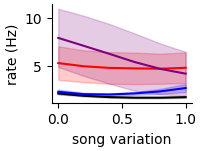

In [12]:
fig, ax = plt.subplots(1, figsize=(2,1.5))

m = rate_onm.mean(axis=-1)

for i, c in enumerate(case_colors):
    plot_mean_std(ax, m[:,i].mean(axis=0), m[:,i].std(axis=0), 
                  a_fill=0.2, c=c, xs=XS_PERT)
pvals = np.zeros((len(case_names), m.shape[-1]))
for i in range(len(case_names)):
    for j in range(m.shape[-1]):
        pvals[i,j] = ranksums(m[:,0,j], m[:,i,j]).pvalue
print(pvals)
ax.set(xlabel='song variation', ylabel='rate (Hz)')
fig.savefig(f'../svg/EIrec_analysis/{mode}_on_manifold_perturb_unnormalized.svg')

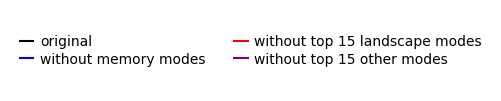

In [13]:
fig, ax = plt.subplots(1, figsize=(5,1))
for n, c in zip(case_names, case_colors):
    ax.plot(0, 0, c=c, label=n)
ax.set_axis_off()
ax.legend(loc='center', ncols=2, columnspacing=2)
fig.savefig(f'../svg/EIrec_analysis/dummy_label_EIrec_analysis.svg')

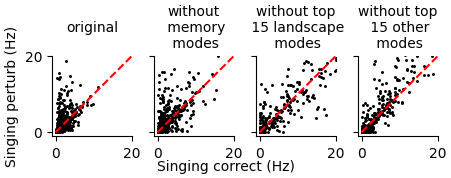

In [14]:
fig, ax = plt.subplots(1, n_case, sharex='all', sharey='all', figsize=(4.5, 2))
l = rng.integers(0, rate_onm.shape[0])
i_ctrl = 0 # index of singing correct
i_pert = -1 # index of singing perturb
for i, k in enumerate(case_names):
    z_ctrl = rate_offm[l,i,i_ctrl]
    z_pert = rate_offm[l,i,i_pert]
    ax[i].scatter(z_ctrl, z_pert, c='k', s=5, zorder=-1)
    ax[i].plot([0,50], [0,50], c='r', ls='--')
    k = k.split(' ')
    k[len(k)//4] = k[len(k)//4] + '\n'
    if len(k) > 1:
        k[-2] = k[-2] + '\n'
    k = ' '.join(k)
    ax[i].set(aspect=1, title=k, xlim=[-1,20], ylim=[-1,20])
    ax[i].set_rasterization_zorder(0)
ax[0].set(ylabel='Singing perturb (Hz)', xlabel='\n')
fig.text(0.5, 0.15, 'Singing correct (Hz)', ha='center', va='center')
fig.savefig(f'../svg/EIrec_analysis/{mode}_joint_dist_J_disrupt_pert.svg')

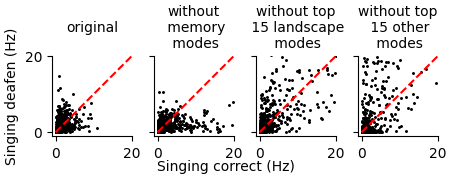

In [15]:
fig, ax = plt.subplots(1, n_case, sharex='all', sharey='all', figsize=(4.5, 2))
l = rng.integers(0, rate_onm.shape[0])
i_ctrl = -1 # index of singing correct
i_pert = 0 # index of singing perturb
for i, k in enumerate(case_names):
    z_ctrl = rate_onm[l,i,i_ctrl]
    z_pert = rate_onm[l,i,i_pert]
    ax[i].scatter(z_ctrl, z_pert, c='k', s=5, zorder=-1)
    ax[i].plot([0,50], [0,50], c='r', ls='--')
    k = k.split(' ')
    k[len(k)//4] = k[len(k)//4] + '\n'
    if len(k) > 1:
        k[-2] = k[-2] + '\n'
    k = ' '.join(k)
    ax[i].set(aspect=1, title=k, xlim=[-1,20], ylim=[-1,20])
    ax[i].set_rasterization_zorder(0)
ax[0].set(ylabel='Singing deafen (Hz)', xlabel='\n')
fig.text(0.5, 0.15, 'Singing correct (Hz)', ha='center', va='center')
fig.savefig(f'../svg/EIrec_analysis/{mode}_joint_dist_J_disrupt_deafen.svg')

In [16]:
# fig, ax = plt.subplots(1, 3, figsize=(5, 2))
# for i, (c, j) in enumerate(zip([case_names[_] for _ in (2,1,3)], 
#                                [J_disrupt_land, J_disrupt_mem, J_disrupt_ctrl])):
#     dJ = np.abs(J - j)
#     b = list(map(lambda x: x.flatten(), [dJ[:NE,:NE], dJ[:NE,NE:], dJ[NE:,:NE], dJ[NE:,NE:]]))
#     ax[i].boxplot(b, tick_labels=['$J_{EE}$', '$J_{EI}$', '$J_{IE}$', '$J_{II}$'], 
#                   flierprops={'marker': '.', 'ms': 1})
#     c = c.split(' ')
#     c[0 if 'memory' in c else 1] += '\n'
#     ax[i].set(title=' '.join(c))
# ax[0].set(ylabel='abs. weight change')
# ax[-1].set(ylim=[-0.0005, 0.01], yticks=[0, 0.01])